In [22]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import payments_manager as pm
import numpy as np

#pm.help()
pm.init(debug=True)
pm.info()
df_jo = pm.df('df_jo')
df_jo.info()



Lista de dataframes: ['cr', 'fe', 'cr_cp', 'fe_cp', 'df_jo', 'df_jall']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   amount                      32092 non-null  float64        
 2   stat_cr                     32092 non-null  object         
 3   created_at                  32092 non-null  datetime64[ns] 
 4   user_id                     32092 non-null  int64          
 5   active                      32092 non-null  int64          
 6   moderated_at                21757 non-null  datetime64[ns] 
 7   reimbursement_date          32092 non-null  datetime64[ns] 
 8   cash_request_received_date  24147 non-null  datetime64[ns] 
 9   money_back_date             23915 non-null  datetime64[ns] 
 10  transfer_type               32092 

In [23]:
# Excluir datos de noviembre de 2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]

# Calcular métricas mensuales
monthly_data = df_jo.groupby('Mes_created_at').agg(
    # Calcular total de fees donde 'stat_fe' == 'accepted'
    total_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'accepted'].sum()),

    # Calcular total de adelantos, donde 'cash_request_received_date' no es nulo
    total_adelantos=(
        'id_cr', 
        lambda ids: df_jo.loc[ids.index]
            .drop_duplicates(subset='id_cr')
            .loc[df_jo.loc[ids.index, 'cash_request_received_date'].notna(), 'amount']
            .sum()
    ),
    
    # Calcular total de fees donde 'transfer_type' == 'regular' y 'stat_fe' == 'accepted'
    total_fees_regular=('fee', lambda x: x[
        (df_jo.loc[x.index, 'transfer_type'] == 'regular') & 
        (df_jo.loc[x.index, 'stat_fe'] == 'accepted')
    ].sum()),
    
    # Calcular total de adelantos donde 'transfer_type' == 'regular' y 'cash_request_received_date' no es nulo
    total_adelantos_regular=(
        'amount',
        lambda x: x[df_jo.loc[x.index, 'transfer_type'] == 'regular']
            .loc[df_jo.loc[x.index, 'cash_request_received_date'].notna()]
            .sum()
    ),
    


    # Calcular total de adelantos donde 'transfer_type' == 'instant' y 'cash_request_received_date' no es nulo
    total_adelantos_instant=(
        'amount',
        lambda x: x[df_jo.loc[x.index, 'transfer_type'] == 'instant']
            .loc[df_jo.loc[x.index, 'cash_request_received_date'].notna()]
            .sum()
    ),
    
    # Calcular total de fees donde 'transfer_type' == 'instant' y 'stat_fe' == 'accepted'
    total_fees_instant=('fee', lambda x: x[
        (df_jo.loc[x.index, 'transfer_type'] == 'instant') & 
        (df_jo.loc[x.index, 'stat_fe'] == 'accepted')
    ].sum())
).reset_index()

# Calcular el ratio de fees sobre adelantos
monthly_data['fees_ratio'] = monthly_data['total_fees'] / monthly_data['total_adelantos'] * 100

# Calcular el ratio de fees sobre adelantos para transferencias 'regular'
monthly_data['fees_ratio_regular'] = (
    monthly_data['total_fees_regular'] / monthly_data['total_adelantos_regular'] * 100
)

# Calcular el ratio de fees sobre adelantos para transferencias 'instant'
monthly_data['fees_ratio_instant'] = (
    monthly_data['total_fees_instant'] / monthly_data['total_adelantos_instant'] * 100
)

# Mostrar la evolución mensual
print(monthly_data)

   Mes_created_at  total_fees  total_adelantos  total_fees_regular  \
0         2019-11         0.0              0.0                 0.0   
1         2019-12         0.0          16349.0                 0.0   
2         2020-01         0.0          10579.0                 0.0   
3         2020-02         0.0          10625.0                 0.0   
4         2020-03         0.0          16200.0                 0.0   
5         2020-04         0.0          31333.0                 0.0   
6         2020-05       520.0          57223.0               520.0   
7         2020-06      4685.0         153973.0              4685.0   
8         2020-07      5160.0         184061.0              4130.0   
9         2020-08     11695.0         178451.0               850.0   
10        2020-09     16785.0         224121.0               310.0   
11        2020-10     34840.0         459082.0               225.0   

    total_adelantos_regular  total_adelantos_instant  total_fees_instant  \
0            

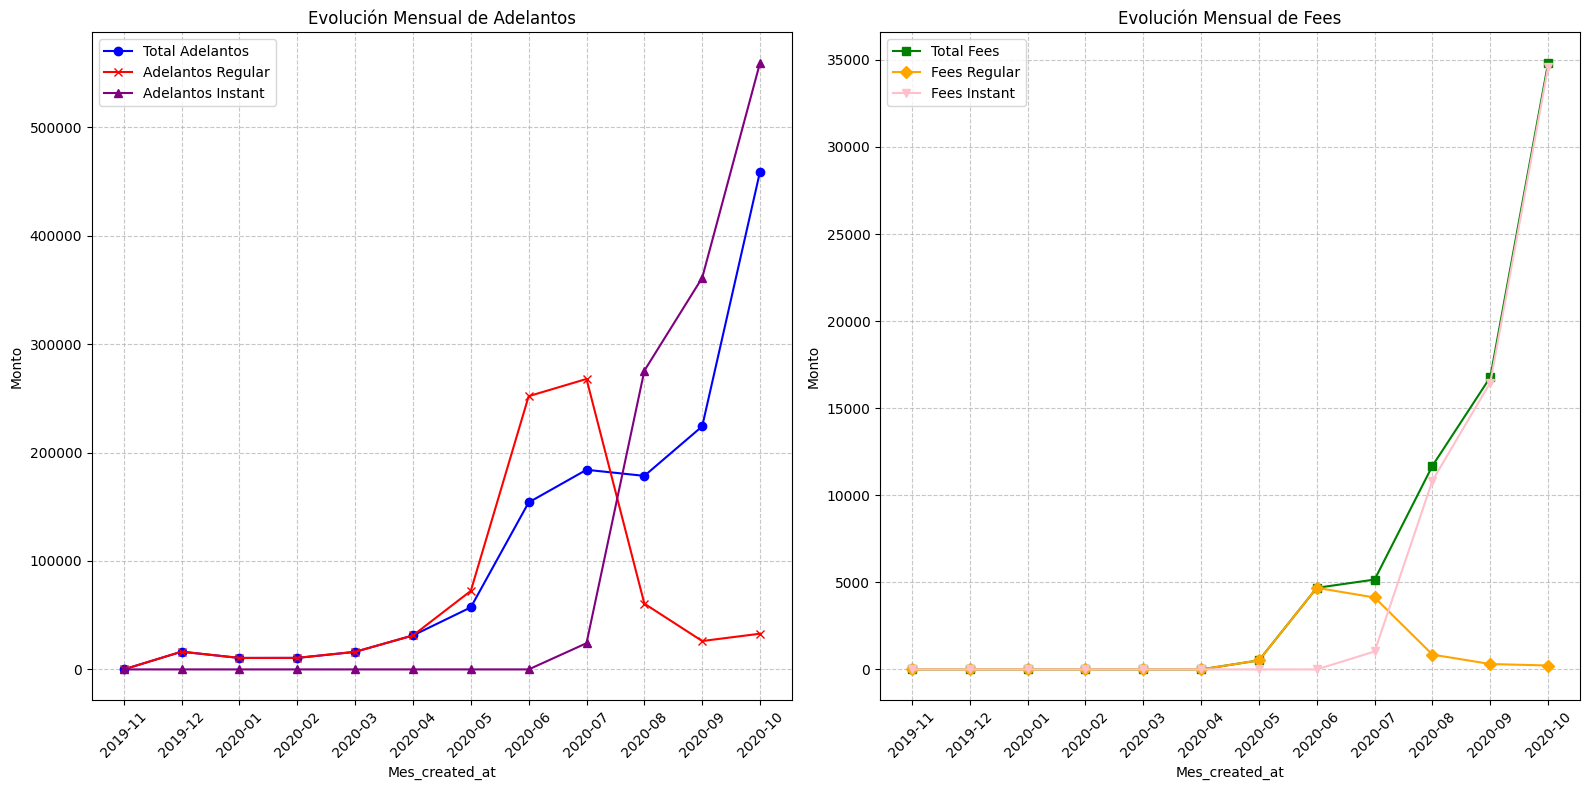

In [24]:
# Crear la figura y los ejes para dos gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Graficar adelantos en el primer gráfico
ax1.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_adelantos'], 
    marker='o', 
    label='Total Adelantos', 
    color='blue'
)
ax1.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_adelantos_regular'], 
    marker='x', 
    label='Adelantos Regular', 
    color='red'
)
ax1.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_adelantos_instant'], 
    marker='^', 
    label='Adelantos Instant', 
    color='purple'
)

# Configurar etiquetas y título para el gráfico de adelantos
ax1.set_xlabel('Mes_created_at')
ax1.set_ylabel('Monto')
ax1.set_title('Evolución Mensual de Adelantos')
ax1.legend()  # Mostrar la leyenda para las líneas
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Graficar fees en el segundo gráfico
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_fees'], 
    marker='s', 
    label='Total Fees', 
    color='green'
)
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_fees_regular'], 
    marker='D', 
    label='Fees Regular', 
    color='orange'
)
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_fees_instant'], 
    marker='v', 
    label='Fees Instant', 
    color='pink'
)

# Configurar etiquetas y título para el gráfico de fees
ax2.set_xlabel('Mes_created_at')
ax2.set_ylabel('Monto')
ax2.set_title('Evolución Mensual de Fees')
ax2.legend()  # Mostrar la leyenda para las líneas
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Ajustar el layout para que todo se vea bien
plt.tight_layout()

# Mostrar los gráficos
plt.show()


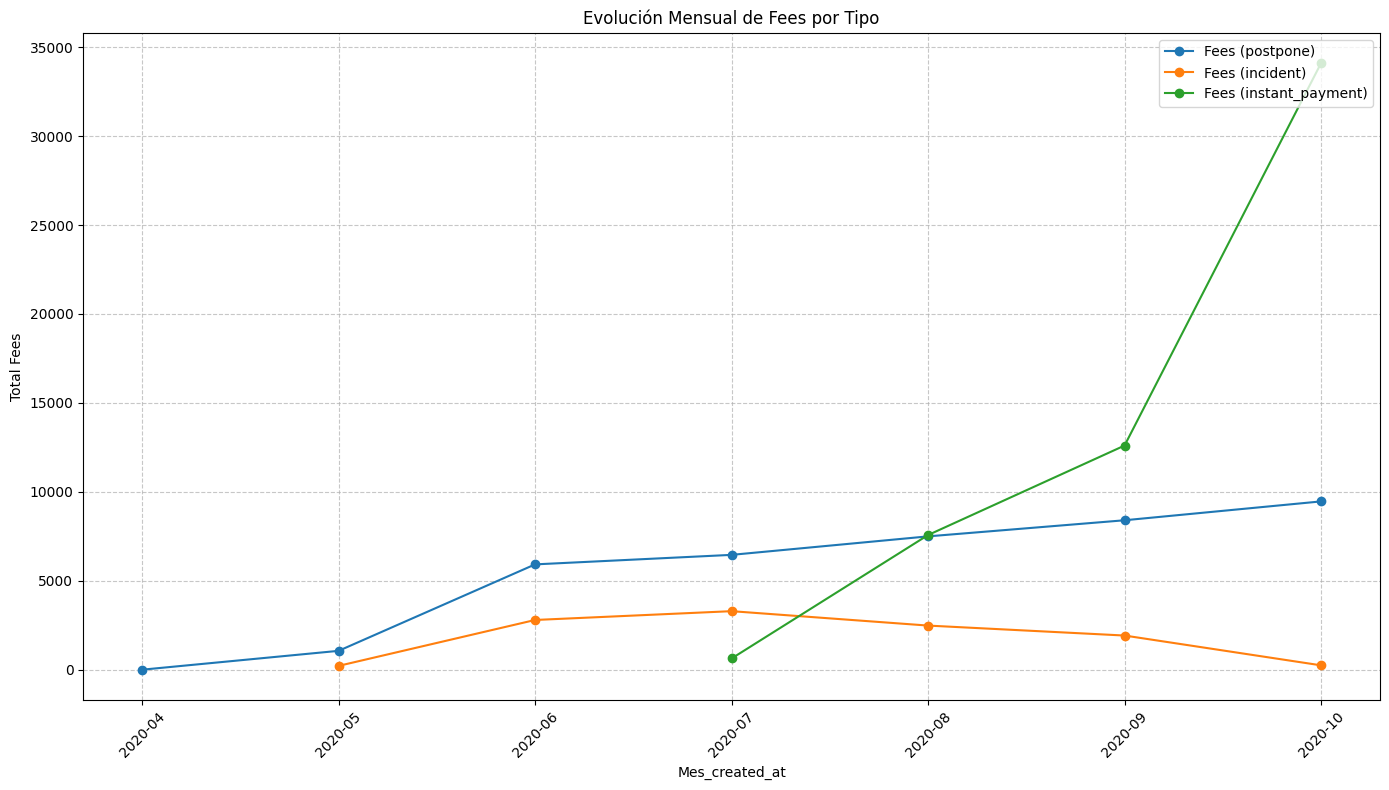

In [26]:
# Excluir datos de noviembre de 2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]

# Filtrar los datos por tipos específicos
filtered_data = df_jo[df_jo['type'].isin(['incident', 'postpone', 'instant_payment'])]

# Ordenar por 'Mes_created_at' en orden ascendente
filtered_data = filtered_data.sort_values(by='Mes_created_at', ascending=True)

# Agrupar por mes y tipo, calculando el total de fees
fees_by_type = filtered_data.groupby(['Mes_created_at', 'type'])['fee'].sum().reset_index()

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(14, 8))

# Obtener los tipos únicos y asignar colores
types = fees_by_type['type'].unique()
colors = plt.cm.tab10(range(len(types)))

# Graficar los fees por cada tipo
for t, color in zip(types, colors):
    type_data = fees_by_type[fees_by_type['type'] == t]
    ax.plot(
        type_data['Mes_created_at'].astype(str),  # Convertir fechas a cadenas
        type_data['fee'],  # Monto de fees
        marker='o', 
        label=f'Fees ({t})', 
        color=color
    )

# Configurar etiquetas y título
ax.set_xlabel('Mes_created_at')
ax.set_ylabel('Total Fees')
ax.set_title('Evolución Mensual de Fees por Tipo')
ax.legend(loc='upper right')  # Mostrar la leyenda
ax.grid(True, linestyle='--', alpha=0.7)

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

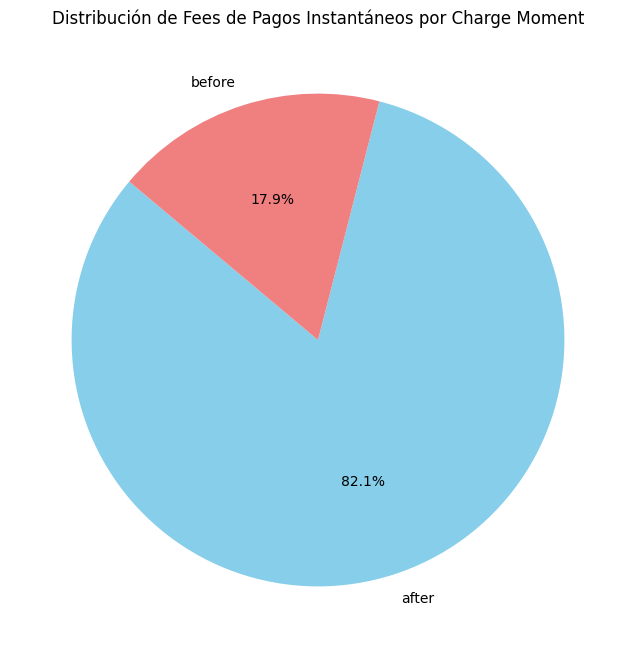

In [39]:
# Filtrar pagos instantáneos
instant_fees = df_jo[df_jo['transfer_type'] == 'instant']

# Agrupar por charge_moment y calcular la suma total de fees
fees_by_charge_moment = (
    instant_fees.groupby('charge_moment')['fee']
    .sum()
    .reset_index()
)

# Crear el gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(
    fees_by_charge_moment['fee'], 
    labels=fees_by_charge_moment['charge_moment'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['skyblue', 'lightcoral']
)

# Configurar el título
plt.title('Distribución de Fees de Pagos Instantáneos por Charge Moment')

# Mostrar el gráfico
plt.show()

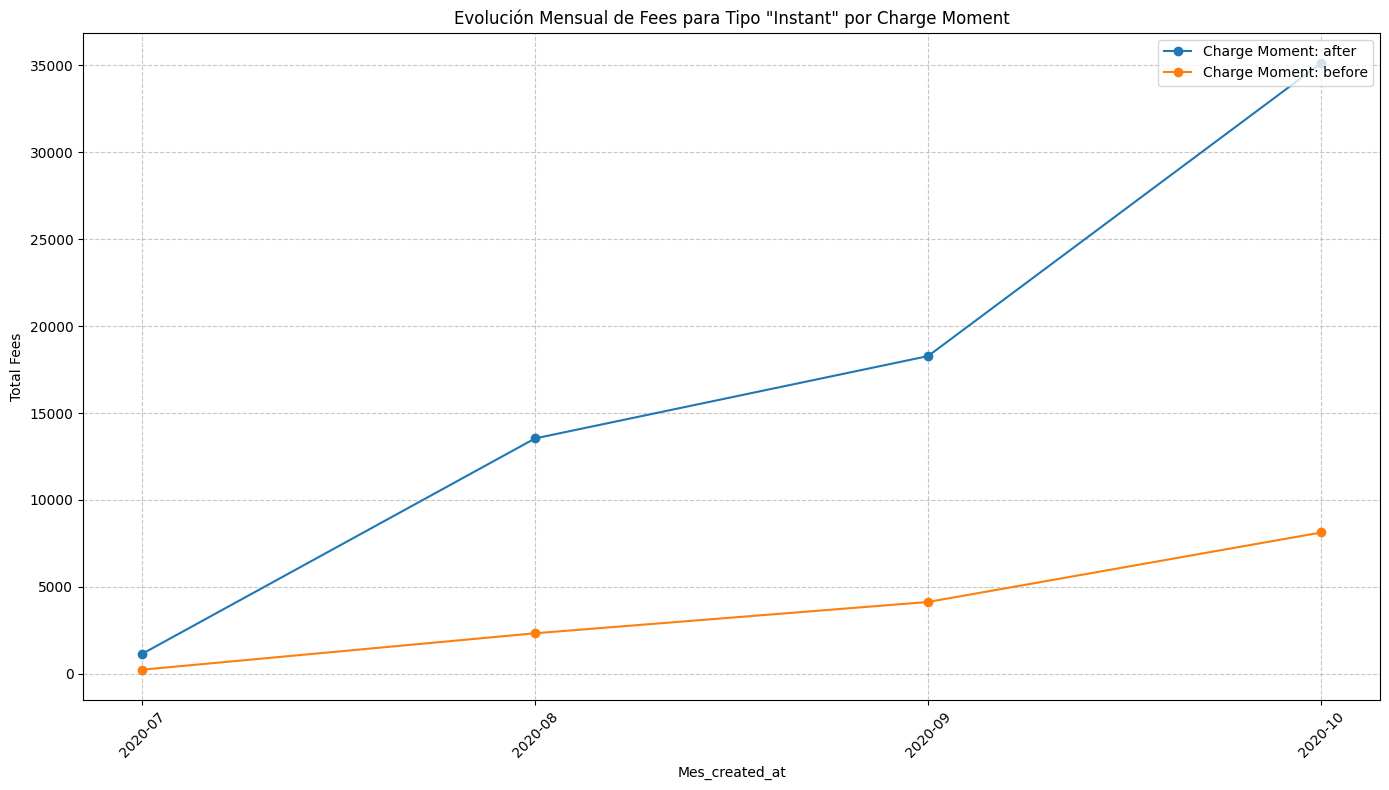

In [47]:
# Filtrar datos por el tipo 'instant'
instant_data = df_jo[df_jo['transfer_type'] == 'instant']

# Agrupar por 'Mes_created_at' y 'charge_moment', calculando el total de fees
fees_by_charge_moment = instant_data.groupby(['Mes_created_at', 'charge_moment'])['fee'].sum().reset_index()

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(14, 8))

# Obtener los valores únicos de 'charge_moment' y asignar colores
charge_moments = fees_by_charge_moment['charge_moment'].unique()
colors = plt.cm.tab10(range(len(charge_moments)))

# Graficar los fees por cada momento de cargo
for cm, color in zip(charge_moments, colors):
    charge_moment_data = fees_by_charge_moment[fees_by_charge_moment['charge_moment'] == cm]
    ax.plot(
        charge_moment_data['Mes_created_at'].astype(str),  # Convertir fechas a cadenas
        charge_moment_data['fee'],  # Monto de fees
        marker='o', 
        label=f'Charge Moment: {cm}', 
        color=color
    )

# Configurar etiquetas y título
ax.set_xlabel('Mes_created_at')
ax.set_ylabel('Total Fees')
ax.set_title('Evolución Mensual de Fees para Tipo "Instant" por Charge Moment')
ax.legend(loc='upper right')  # Mostrar la leyenda
ax.grid(True, linestyle='--', alpha=0.7)

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()



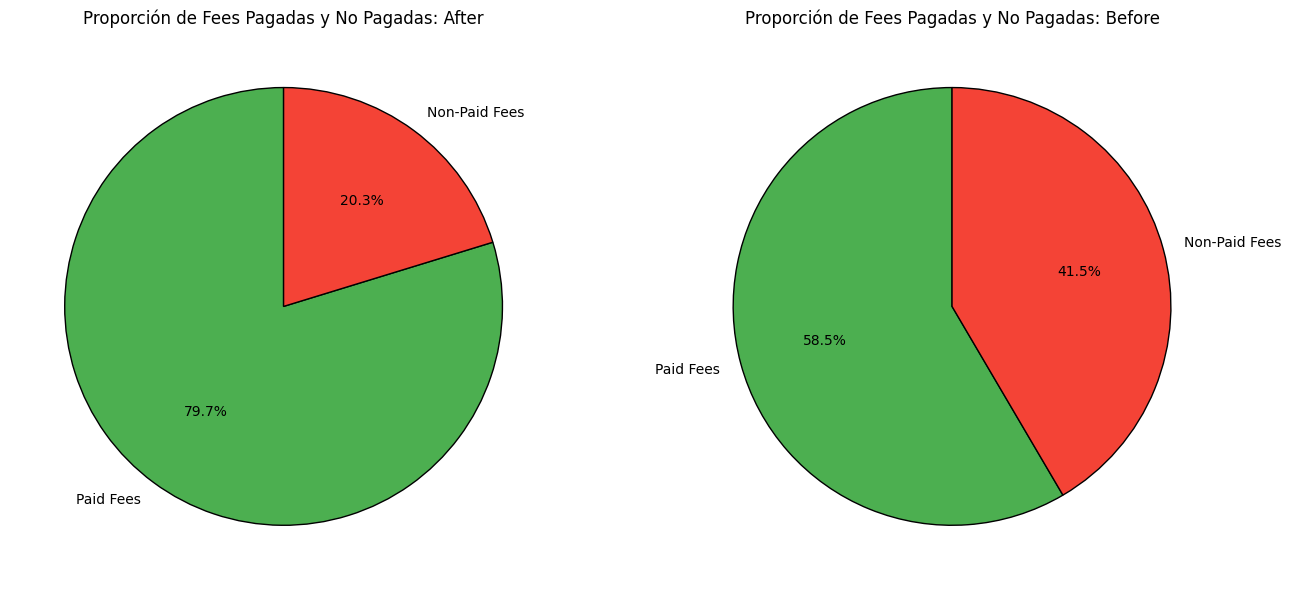

In [48]:
# Filtrar pagos instantáneos
instant_fees = df_jo[df_jo['transfer_type'] == 'instant']

# Agrupar por charge_moment y calcular métricas
fees_summary = instant_fees.groupby('charge_moment').agg(
    paid_fees=('stat_fe', lambda x: (x == 'accepted').sum()),
    non_paid_fees=('stat_fe', lambda x: (x != 'accepted').sum()),
).reset_index()

# Crear gráficos de pastel para 'before' y 'after'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 2 subgráficos (1 fila, 2 columnas)

# Iterar sobre cada grupo charge_moment (before, after)
for idx, moment in enumerate(fees_summary['charge_moment'].unique()):
    data = fees_summary[fees_summary['charge_moment'] == moment]
    
    # Datos para el gráfico de pastel
    labels = ['Paid Fees', 'Non-Paid Fees']
    sizes = [data['paid_fees'].values[0], data['non_paid_fees'].values[0]]
    colors = ['#4caf50', '#f44336']  # Colores para las porciones

    # Graficar el pastel en el subgráfico correspondiente
    axes[idx].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    axes[idx].set_title(f'Proporción de Fees Pagadas y No Pagadas: {moment.capitalize()}')

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()



INSIGHT: SERVICIO DE COBRO POR ANTICIPADO DE FEES NOS AFECTA A LA COBRABILIDAD DE ESTOS FEES. SUGIERO QUITAR ESTE SERVICIO

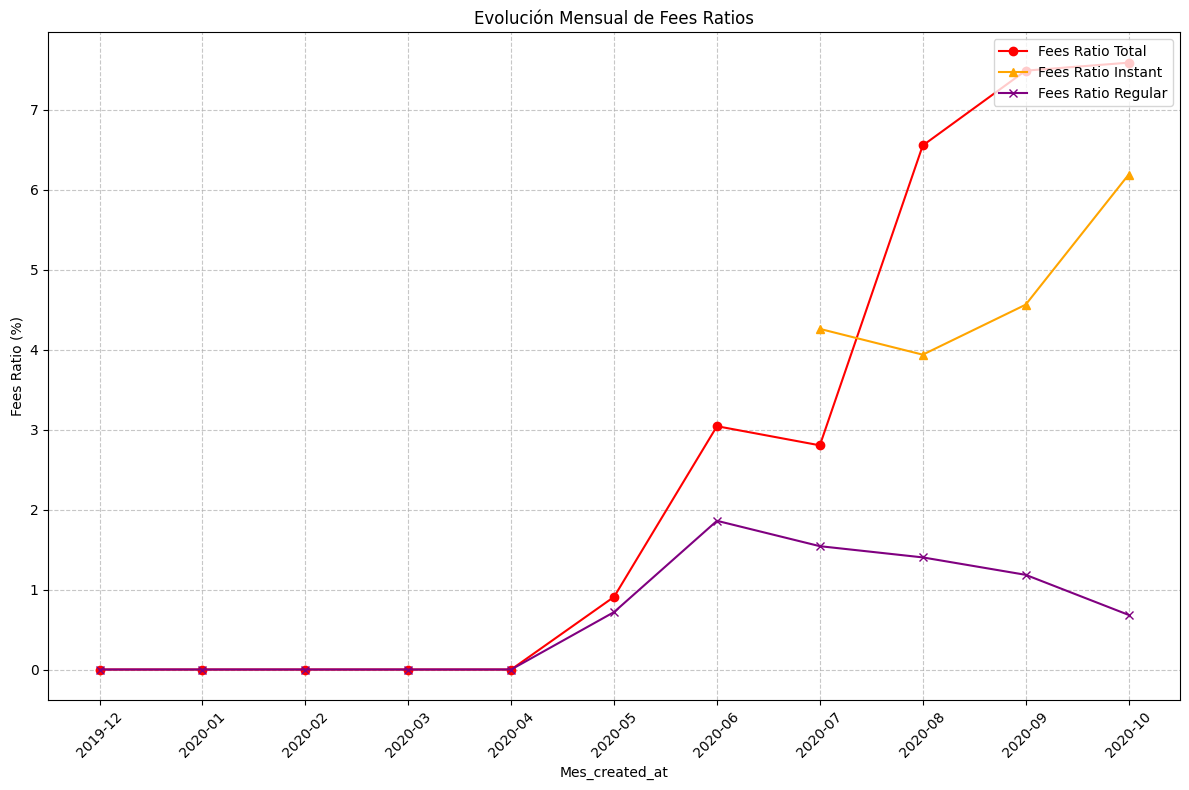

In [27]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar los tres ratios en el eje principal
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['fees_ratio'], 
    marker='o', 
    label='Fees Ratio Total', 
    color='red'
)
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['fees_ratio_instant'], 
    marker='^', 
    label='Fees Ratio Instant', 
    color='orange'
)
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['fees_ratio_regular'], 
    marker='x', 
    label='Fees Ratio Regular', 
    color='purple'
)

# Configurar etiquetas y título
ax.set_xlabel('Mes_created_at')
ax.set_ylabel('Fees Ratio (%)')
ax.set_title('Evolución Mensual de Fees Ratios')
ax.legend(loc='upper right')  # Mostrar la leyenda
ax.grid(True, linestyle='--', alpha=0.7)

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()


In [55]:
# Filtrar el DataFrame para clientes con transfer_type 'regular' y 'instant'
regular_clients = df_jo[df_jo['transfer_type'] == 'regular']
instant_clients = df_jo[df_jo['transfer_type'] == 'instant']

# Identificar los usuarios únicos en cada tipo de transferencia
regular_users = set(regular_clients['user_id'].unique())
instant_users = set(instant_clients['user_id'].unique())

# Clientes con 'regular' o 'instant' solamente (sin mezcla)
regular_only_users = regular_users - instant_users
instant_only_users = instant_users - regular_users

# Clientes con una mezcla de 'regular' e 'instant'
mix_users = regular_users & instant_users

# Crear el DataFrame con el conteo de usuarios únicos por cohorte
cohorts = {
    'Regular': len(regular_only_users),
    'Instant': len(instant_only_users),
    'Mix': len(mix_users)
}

cohorts_df = pd.DataFrame(list(cohorts.items()), columns=['Cohort', 'Unique Users'])

# Definir una función para calcular las métricas para cada cohorte
def calculate_metrics(users):
    # Filtrar el DataFrame para los usuarios de la cohorte
    cohort_df = df_jo[df_jo['user_id'].isin(users)]
    
    # Calcular fees pagados (donde 'stat_fe' == 'accepted')
    fees_paid = cohort_df[cohort_df['stat_fe'] == 'accepted']['fee'].sum()
    
    # Calcular el número de solicitudes únicas
    num_solicitudes = cohort_df['id_cr'].nunique()
    
    # Calcular LTV (valor de vida del cliente)
    ltv = fees_paid / num_solicitudes if num_solicitudes > 0 else 0
    
    return fees_paid, num_solicitudes, ltv

# Calcular las métricas para cada cohorte
regular_fees_paid, regular_num_solicitudes, regular_ltv = calculate_metrics(regular_only_users)
instant_fees_paid, instant_num_solicitudes, instant_ltv = calculate_metrics(instant_only_users)
mix_fees_paid, mix_num_solicitudes, mix_ltv = calculate_metrics(mix_users)

# Crear el DataFrame con las métricas
cohorts = {
    'Cohort': ['Regular', 'Instant', 'Mix'],
    'Unique Users': [len(regular_only_users), len(instant_only_users), len(mix_users)],
    'Fees Paid': [regular_fees_paid, instant_fees_paid, mix_fees_paid],
    'Num Solicitudes': [regular_num_solicitudes, instant_num_solicitudes, mix_num_solicitudes],
    'LTV': [regular_ltv, instant_ltv, mix_ltv]
}

cohorts_df = pd.DataFrame(cohorts)

# Mostrar el resultado
print(cohorts_df)


    Cohort  Unique Users  Fees Paid  Num Solicitudes       LTV
0  Regular          2379     4270.0             4165  1.025210
1  Instant          6972    39425.0             8729  4.516554
2      Mix          2511    29990.0            10934  2.742821
